# Image classification of six-sided dice
### Using Keras and a LeNet-5 inspired Convolutional Neural Network

This part of the project made use of Mario Lurig's dice image dataset, linked at the bottom of this cell. For this project I focused on six-sided dice, but the dataset includes many different kinds of dice.

The dice image dataset (as published on kaggle) was unlabled. However, the ordering of the images made it relatively quick to label - there are 100-200 images in a row of the same die (from different angles). I used an open excel sheet to extended the same label across several hundred images at a time, to label the groups of images in bulk, which took 10 minutes, tops. I've provided the labels in `data/kaggle_labels/{test/train}.txt`. The files are split identically to the test/train split on kaggle, with a column for filename (identical to the filename on kaggle) and a column for label (an integer between 1 and 6).

https://www.kaggle.com/ucffool/dice-d4-d6-d8-d10-d12-d20-images

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import h5py
import tensorflow as tf
from tensorflow.python.framework import ops
from PIL import Image
import glob, os
%matplotlib inline

In [3]:
# path to local image directory, change as you see fit
LOCAL_IMAGE_DIR = '/Users/ebyler/research/ml/dice'

# path to local dice_detection repository
WORKING_DIR = '/Users/ebyler/gh/dice_detection'
DATA_DIR = WORKING_DIR+'/data/kaggle_labels'

In [4]:
# list of image filenames in the training set
data_train = np.genfromtxt(DATA_DIR+'/train.txt',
                           names='fnames, Y',
                          dtype=None, delimiter=',', encoding=None)

# list of image filenames in the test set
data_test = np.genfromtxt(DATA_DIR+'/test.txt',
                          names='fnames, Y',
                          dtype=None, delimiter=',', encoding=None)

### Example of what the data looks like

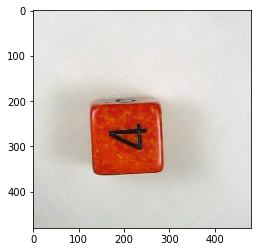

In [5]:
# grab a random image from the list of filenames
randomFile = np.random.choice(data_train['fnames'], size=1)
# pull full path for local image directory
testFile = '/'.join([LOCAL_IMAGE_DIR, 'train', randomFile[0]])
# display image
image = mpimg.imread(testFile)
plt.imshow(image)

# Resize images
I ran this model from my macbook, which is not particularly computationally beefy. To accomodate the limited memory, I resized all of the kaggle images (408 x 408) to 64x64 pixels, and then stored the 64x64x3 image arrays in hdf5 files, along with a one-hot classification.

In [6]:
size = 64, 64

for infile in glob.glob(LOCAL_IMAGE_DIR+"/train/*.jpg"):
    file, ext = os.path.splitext(infile)
    im = Image.open(infile)
    im.thumbnail(size)
    im.save(file + ".thumbnail", "PNG")
    
for infile in glob.glob(LOCAL_IMAGE_DIR+"/test/*.jpg"):
    file, ext = os.path.splitext(infile)
    im = Image.open(infile)
    im.thumbnail(size)
    im.save(file + ".thumbnail", "PNG")

### Generate h5 files for train/test sets

In [7]:
def quick_one_hot(Y_orig, labels):
    '''
    Y_orig is array of shape (m_examples,)
    labels is unique array of values in Y_orig
        of shape (num_labels)
    Output: array of shape (m, num_labels)
        >>> labels 1-6 correspond to index 0-5 (0-index)
    Note: you can also use 
          keras.utils.to_categorical(y, num_classes)
    '''
    m = Y_orig.shape[0]
    num_labels = len(labels)
    # broadcasting
    Y_labs = np.ones((m, num_labels))*Y_orig[:,None]
    Y_inds = np.arange(1, num_labels+1)[None,:]*np.ones((m, num_labels))
    Y = (Y_inds == Y_labs)*1. # m_test x num_labels
    return Y

In [8]:
def create_h5_output(data, subdir='train', outfile = 'train.txt'):
    '''
    input: data (np.recarray of image names, labels)
           subdir ('train', or 'test')
           outfile for hdf5 file ('/path/to/train.hdf5')
    '''
    labels = np.unique(data['Y'])
    numb_labels = len(labels)
    m = len(data['fnames'])
    
    # grab list of images
    fileList = np.array(['/'.join([LOCAL_IMAGE_DIR,
                                   subdir,
                                   data['fnames'][i]])
                         for i in range(m)])
    # initialize output
    X = np.zeros((m, 64, 64, 3))

    for i, file_ in enumerate(fileList):
        img = Image.open(file_.replace('.jpg', '.thumbnail'))
        X[i] = np.asarray(img)/255.
    # print results
    print('The data set has shape {0}'.format(X.shape))
    # check shape of one-hot
    Y = quick_one_hot(data['Y'], labels)
    print('The output is shape {0}'.format(Y.shape))
    
    # prepare hdf5 file
    hf = h5py.File(outfile, 'w')
    # add X, Y, use subdir to name
    hf.create_dataset('X_{}'.format(subdir),
                      data=X, compression='gzip')
    hf.create_dataset('Y_{}'.format(subdir),
                      data=Y, compression='gzip')
    # close file to write
    hf.close()
    print('Wrote to {}'.format(outfile))
    return

In [9]:
# train data
create_h5_output(data_train, subdir='train',
                 outfile = LOCAL_IMAGE_DIR+'/d6_train.h5')

The data set has shape (4046, 64, 64, 3)
The output is shape (4046, 6)
Wrote to /Users/ebyler/research/ml/dice/d6_train.h5


In [10]:
# test data
create_h5_output(data_test, subdir='test',
                 outfile = LOCAL_IMAGE_DIR+'/d6_test.h5')

The data set has shape (578, 64, 64, 3)
The output is shape (578, 6)
Wrote to /Users/ebyler/research/ml/dice/d6_test.h5


## Read in train/test data

In [11]:
# training set
with h5py.File(LOCAL_IMAGE_DIR+'/d6_train.h5', 'r') as f:
    X_train = np.array(f['X_train'][:])
    Y_train = np.array(f['Y_train'][:])

# test set
with h5py.File(LOCAL_IMAGE_DIR+'/d6_test.h5', 'r') as f:
    X_test = np.array(f['X_test'][:])
    Y_test = np.array(f['Y_test'][:])

# useful numbers
m_test, n_H, n_W, n_C = X_test.shape
m_train, n_y = Y_train.shape

print(f'Number of training examples: {m_train}')
print(f'Number of test examples: {m_test}')
print(f'Dimensions of images: {n_H} x {n_W} x {n_C}')
print(f'Number of output classes: {n_y}')

Number of training examples: 4046
Number of test examples: 578
Dimensions of images: 64 x 64 x 3
Number of output classes: 6


y = [0. 0. 1. 0. 0. 0.]


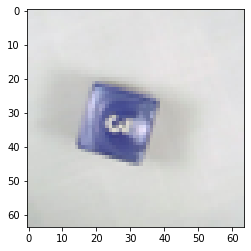

In [12]:
# Example of resized image
index = np.random.choice(X_train.shape[0],1)[0]
plt.imshow(X_train[index])
print ("y = " + str(np.squeeze(Y_train[index])))

## Set up framework for NN

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

Using TensorFlow backend.


In [14]:
# fix some of the hyperparameters
batch_size=32
epochs=100
num_classes = n_y
nfilters = [8, 16]
kernel_sizes = [(4,4), (2,2)]

In [15]:
model = Sequential()

# CONV2D > ReLu > MaxPool
model.add(Conv2D(nfilters[0], kernel_sizes[0], # 8 filters, 4x4
                 strides=(1,1),
                 padding='same', 
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(8,8),
                       strides=(8,8),
                       padding='same'))
# CONV2D > ReLu > MaxPool
model.add(Conv2D(nfilters[1], kernel_sizes[1], # 16 filters, 2x2
                 strides=(1,1),
                 padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4),
                       strides=(4,4),
                       padding='same'))

# Fully connected layer
model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# We will use the Adam optimizer
opt = keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## Optimize

In [29]:
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, Y_test),
          shuffle=True)

Train on 4046 samples, validate on 578 samples
Epoch 1/100
4046/4046 [==============================] - 3s 663us/step - loss: 1.7780 - accuracy: 0.2034 - val_loss: 1.7648 - val_accuracy: 0.2889
Epoch 2/100
4046/4046 [==============================] - 2s 608us/step - loss: 1.7569 - accuracy: 0.3156 - val_loss: 1.7519 - val_accuracy: 0.3183
Epoch 3/100
4046/4046 [==============================] - 2s 578us/step - loss: 1.7437 - accuracy: 0.3010 - val_loss: 1.7381 - val_accuracy: 0.3218
Epoch 4/100
4046/4046 [==============================] - 2s 577us/step - loss: 1.7278 - accuracy: 0.3389 - val_loss: 1.7190 - val_accuracy: 0.3495
Epoch 5/100
4046/4046 [==============================] - 2s 581us/step - loss: 1.7054 - accuracy: 0.3500 - val_loss: 1.6939 - val_accuracy: 0.3841
Epoch 6/100
4046/4046 [==============================] - 2s 600us/step - loss: 1.6770 - accuracy: 0.4192 - val_loss: 1.6622 - val_accuracy: 0.4118
Epoch 7/100
4046/4046 [==============================] - 2s 585us/step 

In [31]:
# Score trained model.
scores = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

578/578 [==============================] - 0s 215us/step
Test loss: 0.23629844518681298
Test accuracy: 0.9480968713760376


### Save trained model

In [32]:
save_dir = LOCAL_IMAGE_DIR+'/models/'
model_name = 'keras_2CONV_trained_model.h5'

In [32]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/ebyler/research/ml/dice/models/keras_2CONV_trained_model.h5 


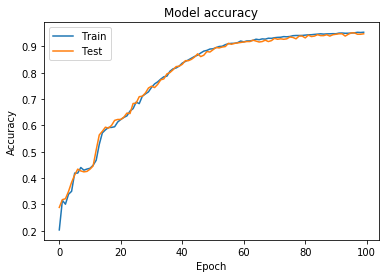

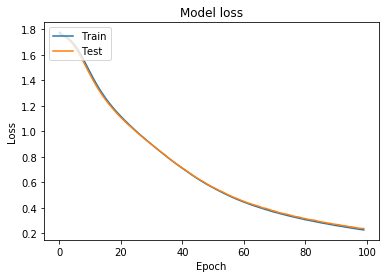

In [37]:
# Plot training & validation accuracy values
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Load previously saved model

In [16]:
from keras.models import load_model
model_path = os.path.join(save_dir, model_name)
model = load_model(model_path)

# Test trained model

Y(true) = [0. 1. 0. 0. 0. 0.]
Y(pred) = [0. 1. 0. 0. 0. 0.]


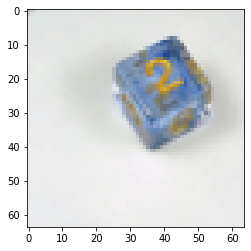

In [31]:
index = np.random.choice(X_test.shape[0],1)[0]
plt.imshow(X_test[index])
print ("Y(true) = " + str(np.squeeze(Y_train[index])))

Y_pred = model.predict_classes(X_test[index:index+1])
Y_vec = keras.utils.to_categorical(Y_pred, num_classes=num_classes)
print ("Y(pred) = " + str(Y_vec[0]))